# Import des Librairies

In [1]:
# pip install xlwt

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler ,LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
from matplotlib.ticker import FixedLocator
import warnings
warnings.filterwarnings("ignore")

In [3]:
!mkdir images

mkdir: images: File exists


# 1. Élaboration d’une base de données de produits alimentaires

In [4]:
# Pré-traitement de la base de données 
df = pd.read_csv('products_database.csv')
df = df.set_index('name')
df.drop_duplicates(keep=False,inplace=True)
df.head(5)

,Energie,Acide Gras,Sucre,Sodium,Proteine,Fibre,Teneur en fruits,nova_grade,nutriscore_grade,nutriscore_score,categories
name,,,,,,,,,,,
Duo de quinoa,502.0,0.5,0.6,204.0,5.0,2.9,0.0,3.0,A,-3,"Aliments et boissons à base de végétaux, Alime..."
Petit Epeautre BIO,701.0,0.3,0.5,192.0,6.4,5.3,0.0,3.0,A,-4,"Aliments et boissons à base de végétaux, Alime..."
Carottes lamelles,154.0,0.1,5.9,20.0,0.5,2.7,100.0,3.0,A,-6,"Aliments et boissons à base de végétaux, Alime..."
LENTILLES VERTES 300 G FRAICHEMENT CUIT by LUNOR,431.0,0.1,0.5,244.0,8.4,5.5,66.0,4.0,A,-9,"Aliments et boissons à base de végétaux, Alime..."
Pommes de terre entière sans peau,329.0,0.1,0.5,68.0,1.1,1.5,0.0,3.0,A,-1,"Aliments et boissons à base de végétaux, Alime..."


In [5]:
## Conversion de notre base de données en fichier excel pour pouvoir l'utiliser par nos méthodes ensuite,
## conformément à la consigne
bdd_excel = df.to_excel("bdd_nutriscore.xlsx")

In [6]:
print('On a',df.shape[0],'aliments dans notre base de données.')

On a 694 aliments dans notre base de données.


In [7]:
print("On remarque bien qu'on a bien au moins 30 aliments par catégorie :")
df['nutriscore_grade'].value_counts()

On remarque bien qu'on a bien au moins 30 aliments par catégorie :


A    311
C    162
D    107
B     58
E     56
Name: nutriscore_grade, dtype: int64

# 2. Élaboration des modèles de Nutri-score basés sur l’approche Électre-Tri

### Voici les fonctions pour implémenter la méthode Électre-Tri

In [8]:
'''
Les paramètres de toutes les fonctions ci-dessous :
    
H : un échantillon de notre base de données dont on cherche à calculer la classe 
lamda : seuil majoritaire (λ)
k : Dictionnaire des poids associé aux 7 critères du Nutri-Score 
bi : Dictionnaire du profil limite i, i allant de 1 à 6
'''

def C(H,bi,k):
    L_min = ['Energie','Acide Gras','Sucre','Sodium']
    L_max = ['Proteine','Fibre','Teneur en fruits']
    S = 0
    for ma in L_max:
        if(H[ma] >= bi[ma]):
            tmp = 1
        else:
            tmp = 0
        tmp = k[ma]*tmp 
        S = S + tmp
        
    for mi in L_min:
        if(bi[mi] >= H[mi]):
            tmp = 1
        else:
            tmp = 0
        tmp = k[mi]*tmp
        S = S + tmp
    
    return S/sum(k.values())
         

def Surclasse(A,B,lamda,k):
    return C(A,B,k) >= lamda


def pessimistic_majority_sorting(H,lamda,k):
    Profils = [b6,b5,b4,b3,b2,b1] 
    C = ['A','B','C','D','E']
    i = 0
    for bi in Profils:
        if(Surclasse(H,bi,lamda,k)):
            return C[i-1]       
        i = i+1
    
    return C[i]
       
    
def optimistic_majority_sorting(H,lamda,k):
    Profils = [b1,b2,b3,b4,b5,b6]
    C = ['E','D','C','B','A']
    i = 0
    for bi in Profils:
        if(Surclasse(bi,H,lamda,k) and (not Surclasse(H,bi,lamda,k))):
            return C[i-1]
        i = i+1
    
    return C[i-1] 

## 2.1 Méthode 1 pour définir les profils limites pour chaque classe
### 2.2.1 Paramétrage des profils limites

Pour paramétrer les profils limites, la première méthode que nous présentons ici consiste à prendre tous les aliments dont le NutriScore est à la frontière entre 2 classes, à savoir tous les aliment qui ont un score qui sont dans la liste suivante : [-1, 2, 10, 18], puis de faire la moyenne pour chaque attributs de tous ces aliments par classe. De cette façon, nous créons un profil limite (c'est-à-dire un aliment qui se situe à la frontière de 2 classes), que nous affectons à nos variables b2, b3, b4, b5 (comme on a 5 classes A, B, C, D, E on a besoin que de 4 profils (b2,b3,b4,b5) pour les délimiter).

Pour les profils b1 et b6, nous leur attribuons des valeurs inatteignable pour nous assurer qu'ils ne puissent être surclassés et ainsi vérifier la condition de la pareto-dominance.


In [9]:
df_mean = df[ (df['nutriscore_score']==-1) | (df['nutriscore_score']==2) | (df['nutriscore_score']==10) | (df['nutriscore_score']==18)].groupby('nutriscore_score').mean()
df_mean


,Energie,Acide Gras,Sucre,Sodium,Proteine,Fibre,Teneur en fruits,nova_grade
nutriscore_score,,,,,,,,
-1,422.636364,0.848485,5.096970,183.636364,5.518182,1.966667,16.959788,3.212121
2,509.637931,2.027414,5.537586,231.482759,6.456379,1.039483,15.932931,3.672414
10,1221.000000,4.300000,17.333333,2343.333333,7.366667,3.566667,23.666667,3.333333
18,1305.571429,11.933333,8.566667,499.809524,14.347619,0.828571,0.795238,3.380952


On réarange certaines colonnes pour avoir la paréto-dominance entre bi+1 et bi

In [10]:
df_mean = df_mean[['Energie', 'Acide Gras', 'Sucre', 'Sodium', 'Proteine', 'Fibre','Teneur en fruits']]
# Définition des dataframes
col1 = df_mean['Energie'].sort_values().reset_index(drop=True)
col2 = df_mean['Acide Gras'].sort_values().reset_index(drop=True)
col3 = df_mean['Sucre'].sort_values().reset_index(drop=True)
col4 = df_mean['Sodium'].sort_values().reset_index(drop=True)
col5 = df_mean['Proteine'].sort_values(ascending=False).reset_index(drop=True)
col6 = df_mean['Fibre'].sort_values(ascending=False).reset_index(drop=True)
col7 = df_mean['Teneur en fruits'].sort_values(ascending=False).reset_index(drop=True)

# Réassemblage des colonnes dans un nouveau dataframe
df_mean = pd.concat([col1, col2, col3, col4, col5, col6, col7], axis=1)

In [11]:
b1 = {'Energie':100000,'Acide Gras':1000,'Sucre':1000,'Sodium':10000,'Proteine':-1,'Fibre':-1,'Teneur en fruits':-1}
b2 = dict(df_mean.loc[3])
b3 = dict(df_mean.loc[2])
b4 = dict(df_mean.loc[1])
b5 = dict(df_mean.loc[0])
b6 = {'Energie':-1,'Acide Gras':-1,'Sucre':-1,'Sodium':-1,'Proteine':300,'Fibre':300,'Teneur en fruits':101}

#### Voila notre dataframe des profils


In [12]:
df_profils = pd.concat([pd.DataFrame(b1,index=['b1']),pd.DataFrame(b2,index=['b2']),pd.DataFrame(b3,index=['b3']),pd.DataFrame(b4,index=['b4']),pd.DataFrame(b5,index=['b5']),pd.DataFrame(b6,index=['b6'])])
df_profils = df_profils.round(decimals=2)
df_profils

,Energie,Acide Gras,Sucre,Sodium,Proteine,Fibre,Teneur en fruits
b1,100000.00,1000.00,1000.00,10000.00,-1.00,-1.00,-1.00
b2,1305.57,11.93,17.33,2343.33,5.52,0.83,0.80
b3,1221.00,4.30,8.57,499.81,6.46,1.04,15.93
b4,509.64,2.03,5.54,231.48,7.37,1.97,16.96
b5,422.64,0.85,5.10,183.64,14.35,3.57,23.67
b6,-1.00,-1.00,-1.00,-1.00,300.00,300.00,101.00


#### Choix des poids

Ici, k est le tableau des poids associés à chaque critère du Nutri-Score donné par la consigne.

On propose une nouvelle façon de définir les poids, en créant un nouveau tableau k1 pour lequel chaque poids correspond à la corrélation entre un critère et la colonne nutriscore de la base de données.

In [13]:
df_correlation = abs(df.corr()[['nutriscore_score']])
k = {'Energie':2,'Acide Gras':2,'Sucre':2,'Sodium':2,'Proteine':1,'Fibre':1,'Teneur en fruits':1}
k1 = {'Energie':float(df_correlation.loc['Energie']),'Acide Gras':float(df_correlation.loc['Acide Gras']),'Sucre':float(df_correlation.loc['Sucre']),'Sodium':float(df_correlation.loc['Sodium']),'Proteine':float(df_correlation.loc['Proteine']),'Fibre':float(df_correlation.loc['Fibre']),'Teneur en fruits':float(df_correlation.loc['Teneur en fruits'])}

In [14]:
df_correlation

,nutriscore_score
Energie,0.699314
Acide Gras,0.687631
Sucre,0.178577
Sodium,0.288522
Proteine,0.418392
Fibre,0.348070
Teneur en fruits,0.508189
nova_grade,0.314218
nutriscore_score,1.000000


#### Voici notre dataframe des poids

In [15]:
df_poids = pd.concat([pd.DataFrame(k,index=['k']),pd.DataFrame(k1,index=['k1'])])
df_poids = df_poids.round(decimals=2)
df_poids

,Energie,Acide Gras,Sucre,Sodium,Proteine,Fibre,Teneur en fruits
k,2.0,2.00,2.00,2.00,1.00,1.00,1.00
k1,0.7,0.69,0.18,0.29,0.42,0.35,0.51


Le code ci-dessous montre bien qu'on a bien une dominance pareto-stricte entre bi+1 et bi

In [16]:
P = [b6,b5,b4,b3,b2,b1] 
y = 6
for i in range(len(P)-1):
    print("b"+str(y-i),",","b"+str(y-(i+1)),", C =",C(P[i],P[i+1],k))

b6 , b5 , C = 1.0
b5 , b4 , C = 1.0
b4 , b3 , C = 1.0
b3 , b2 , C = 1.0
b2 , b1 , C = 1.0


## Comparaison à l'aide de matrices de confusion avec le nutri-score

In [17]:
def afficher_matrice_confusion(nom_fonction,k,n_k,seuil,n):
    '''
    seuil : le seuil de surclassement
    k : le dictionnaire des poids
    n_k : nom du dictionnaire k
    nom_fonction : la fonction optimistic_majority_sorting ou pessimistic_majority_sorting
    
    '''
    
    titre = n + str(nom_fonction).split(' ')[1]+'-'+str(seuil)+'-'+n_k
    df[titre] = df.apply(lambda x : nom_fonction(x,seuil,k),axis=1)
    confusion_matrix = pd.crosstab(df['nutriscore_grade'], df[titre])
    
    # Calcul de précision,recall et f1-score
    report = classification_report(df['nutriscore_grade'], df[titre],output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    avg = round(df_report['f1-score']['macro avg'],2)
    avg_wei = round(df_report['f1-score']['weighted avg'],2)
    L = (avg,avg_wei,titre)
    titre = titre + ' , F1_score_av ='+str(avg)+' , F1_score_av_wei ='+str(avg_wei)
    df_report = df_report.drop(columns='support')
    

    return confusion_matrix,titre,df_report,L
    

### Rapport avec les matrices de confusion pour chaque couple de poids, le seuil majoritaire et les procédures d’affectation Pessimiste et Optimiste de la méthode ÉLECTRE TRI

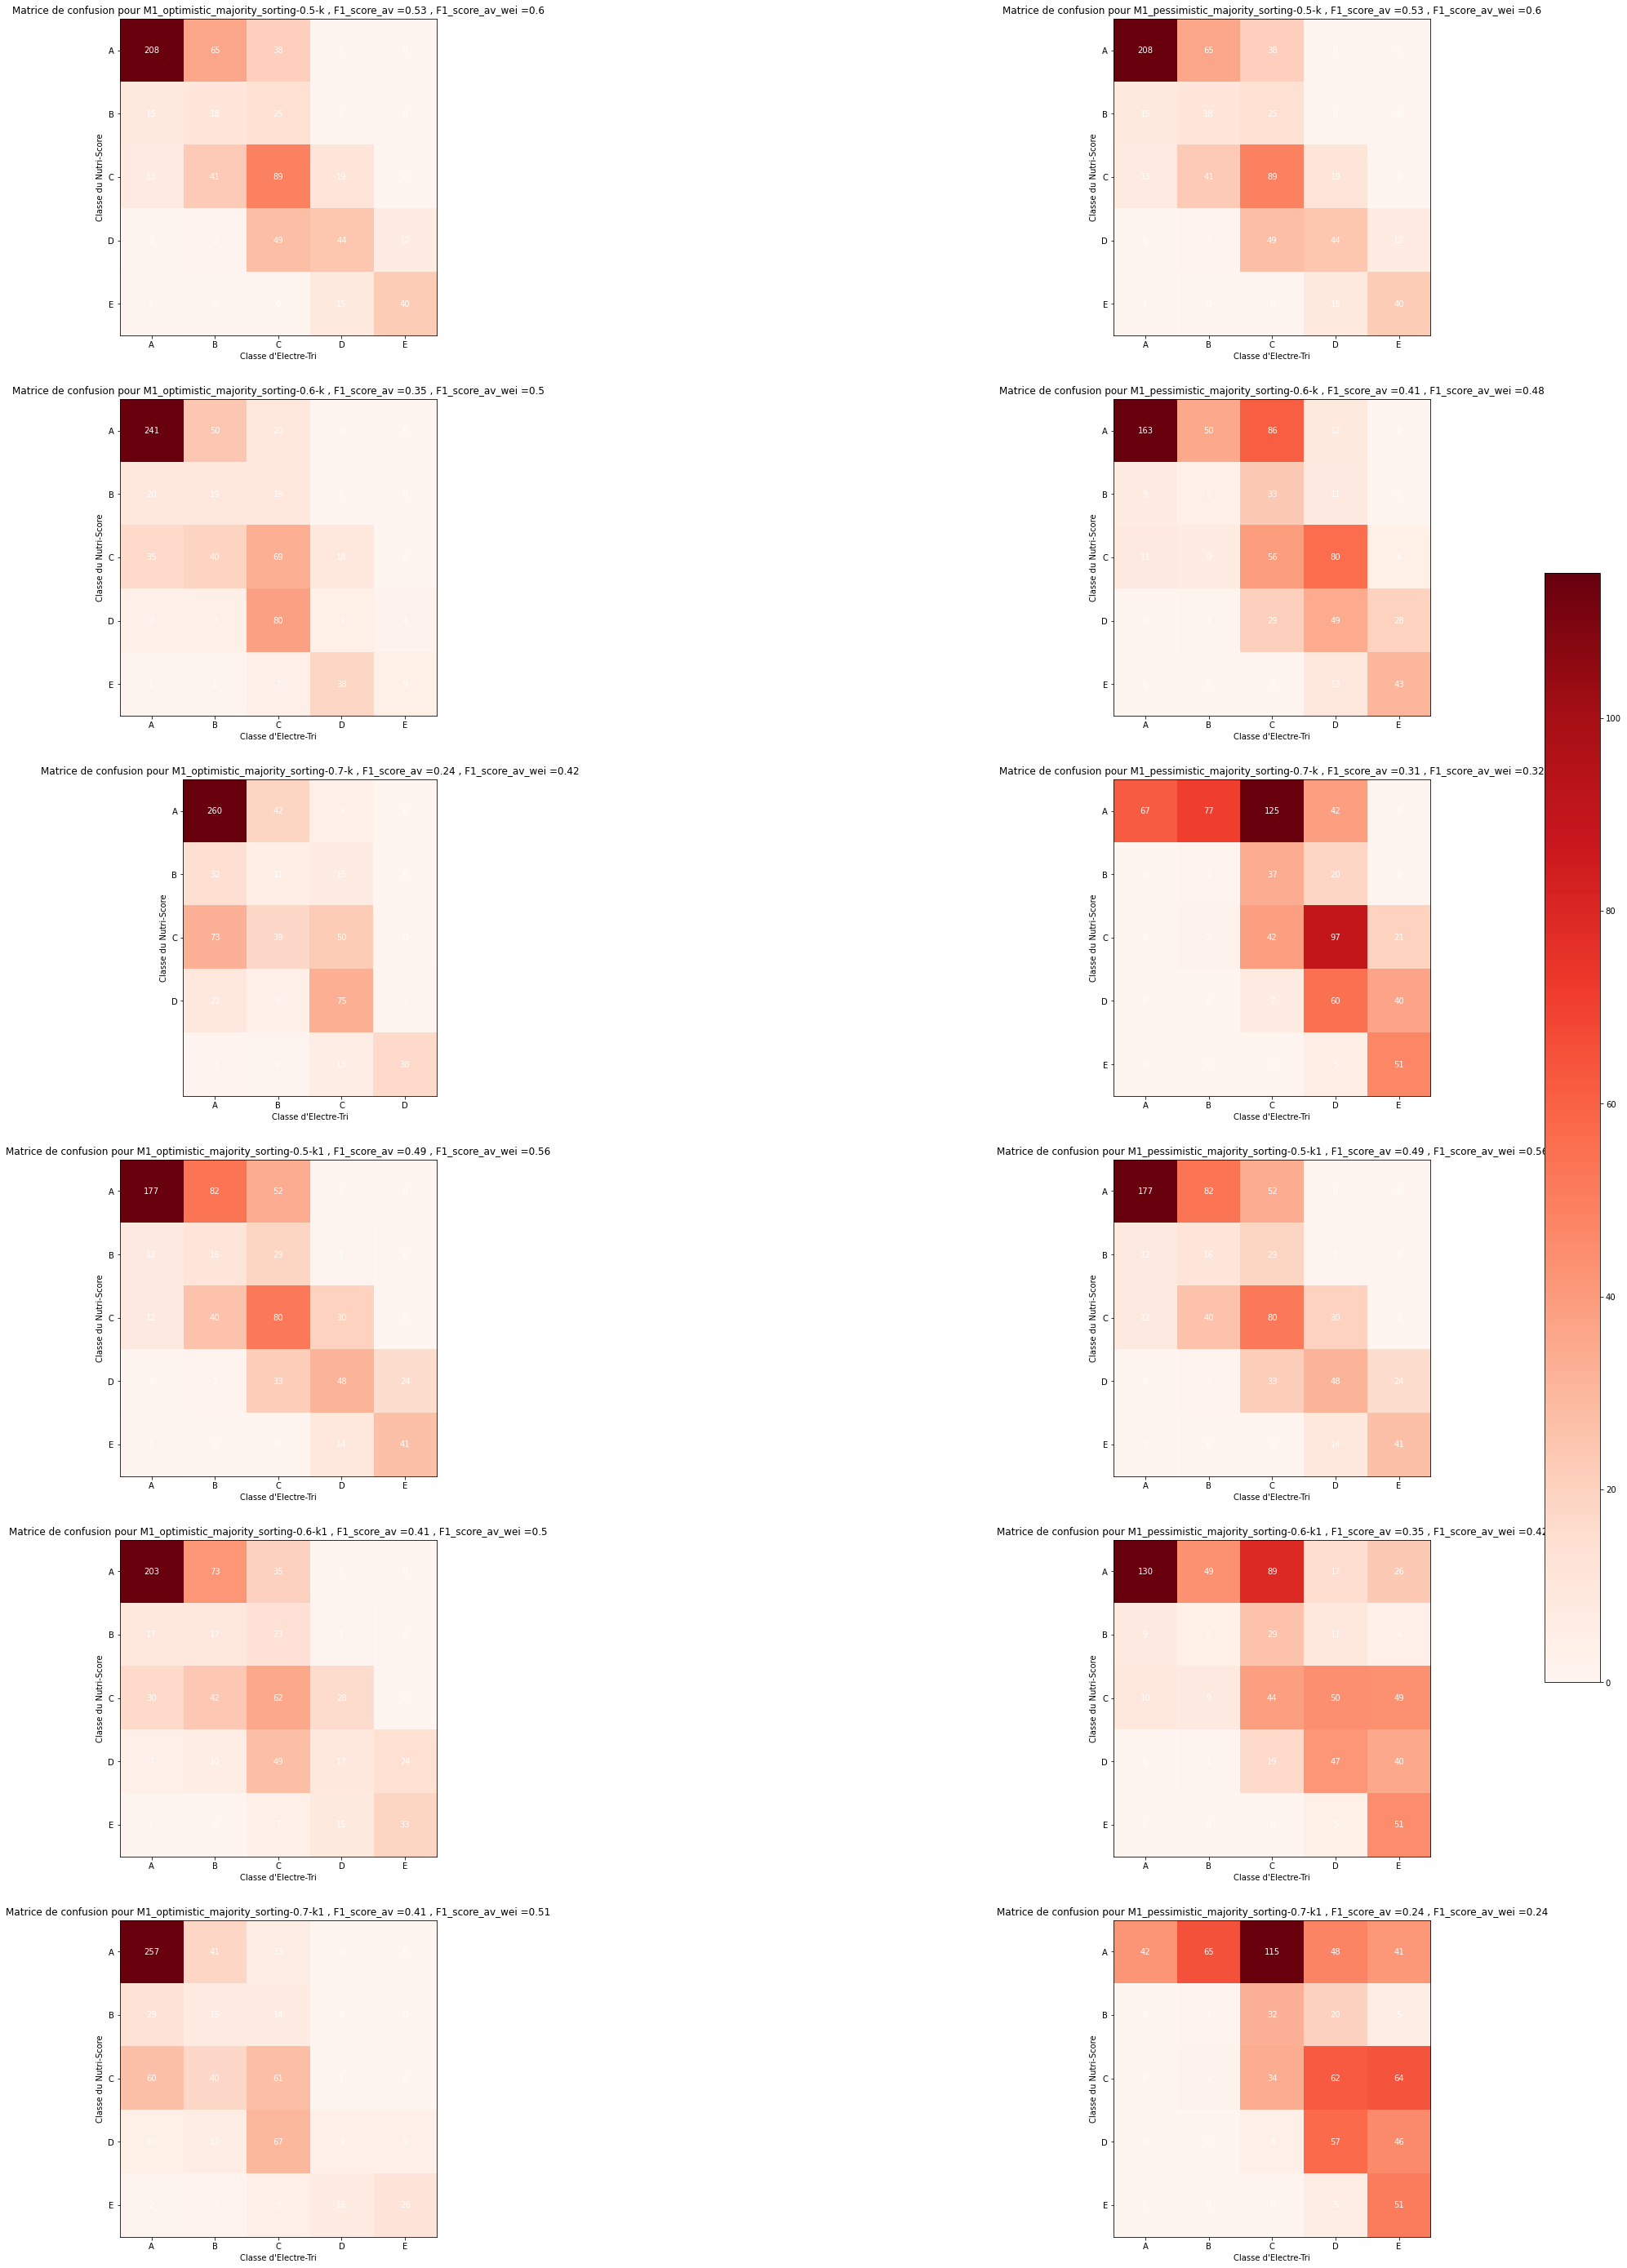

In [18]:
L_k = [(k, 'k'), (k1, 'k1')]
L_s = [0.5, 0.6, 0.7]
L_f = [optimistic_majority_sorting, pessimistic_majority_sorting]
classifiers = []
Reports = []
nb_ligne = 6
nb_col = 2

if nb_ligne * nb_col != len(L_k) * len(L_s) * len(L_f):
    print("erreur de taille")
    exit()

fig, axs = plt.subplots(nb_ligne, nb_col, figsize=(50, 50))
L = []
ims = []
i = 0
ii = 0
for ki in L_k:
    for s in L_s:
        for f in L_f:
            matrice, titre, report, l = afficher_matrice_confusion(f, ki[0], ki[1], s,'M1_')
            L.append(l)
            Reports.append((titre,report))
            x_labels = matrice.columns
            y_labels = matrice.columns
            classifiers.append(matrice)
            im = axs[ii][i % nb_col].imshow(classifiers[i], cmap='Reds')
            axs[ii][i % nb_col].xaxis.set_major_locator(FixedLocator(range(len(x_labels))))
            axs[ii][i % nb_col].set_xticklabels(x_labels)
            axs[ii][i % nb_col].yaxis.set_major_locator(FixedLocator(range(len(y_labels))))
            axs[ii][i % nb_col].set_yticklabels(y_labels)
            axs[ii][i % nb_col].set_title('Matrice de confusion pour ' + titre)
            axs[ii][i % nb_col].set_xlabel("Classe d'Electre-Tri")
            axs[ii][i % nb_col].set_ylabel('Classe du Nutri-Score')
            ims.append(im)
            for u in range(classifiers[i].shape[0]):
                for j in range(classifiers[i].shape[1]):
                    axs[ii][i % nb_col].text(j, u, classifiers[i].iloc[u, j], ha='center', va='center', color='w')
            i += 1
            if i % nb_col == 0:
                ii += 1

fig.colorbar(im, ax=axs, shrink=0.5)
plt.savefig('images/Methode1_matricesDeConfusion.png')
plt.show()

### Rapport avec les Graphique de Recall, Précision et F1-Score pour chaque couple de poids, le seuil majoritaire et les procédures d’affectation Pessimiste et Optimiste de la méthode Électre-Tri


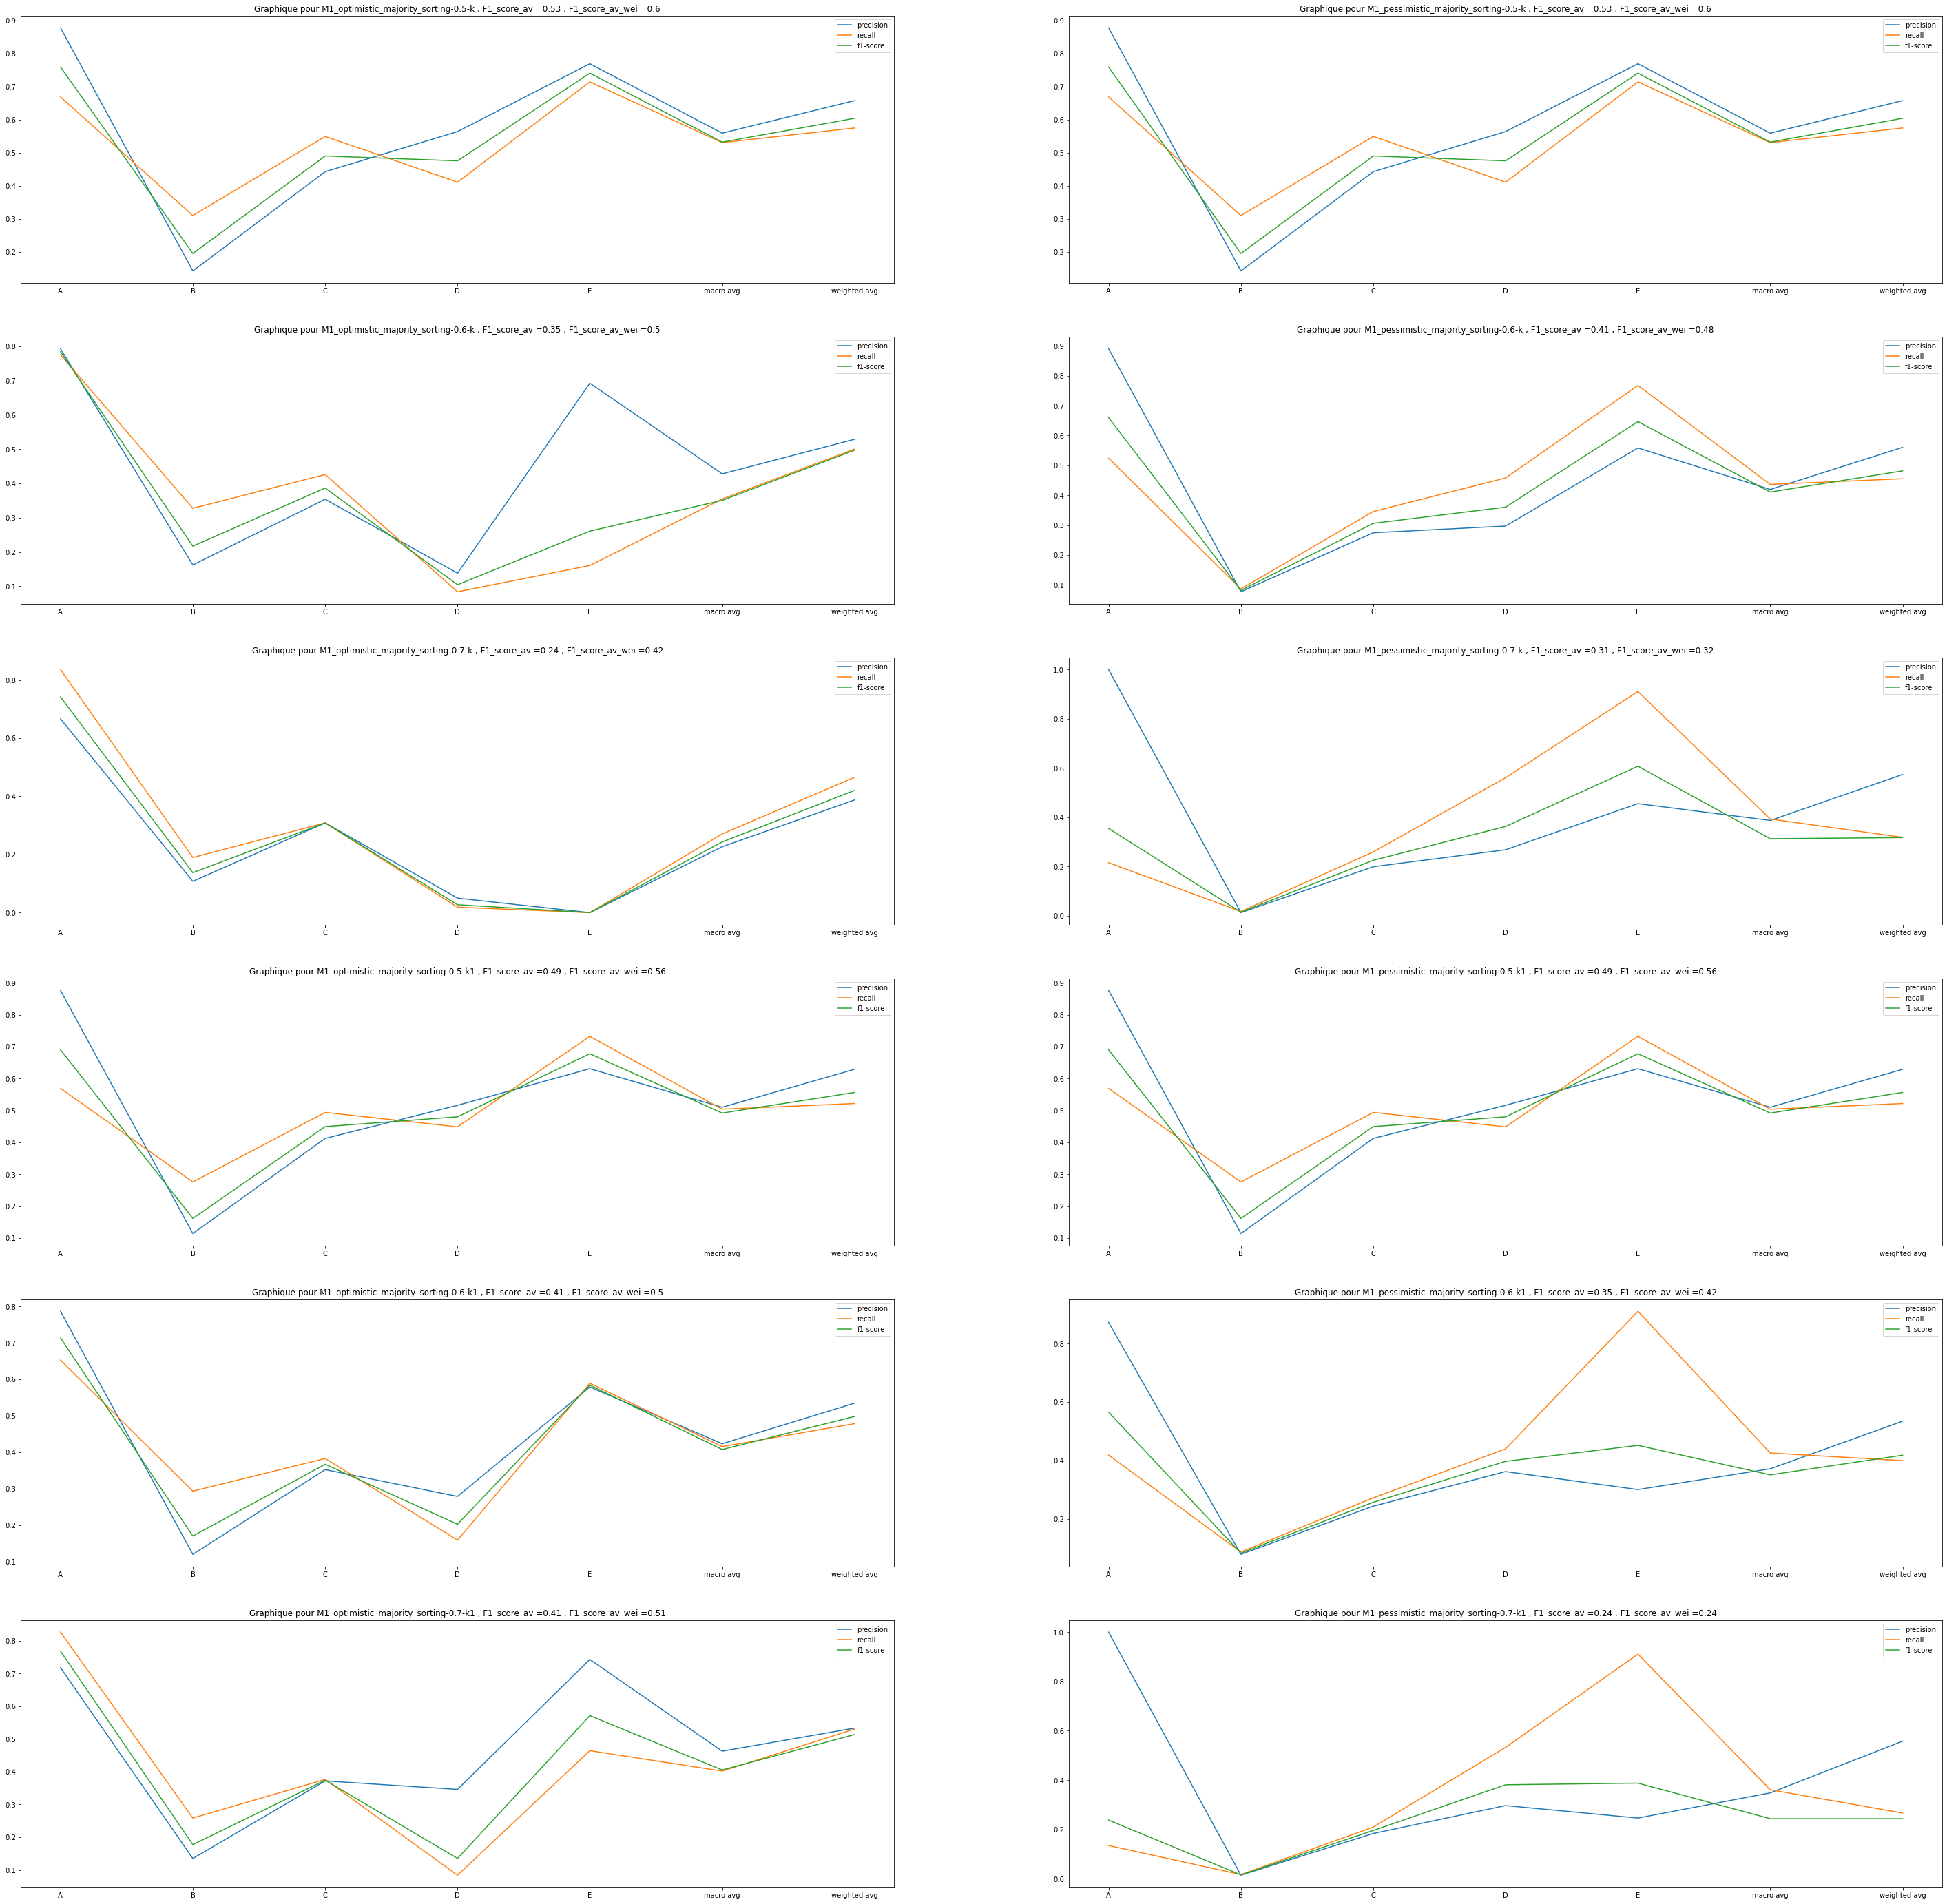

In [19]:
fig, axs = plt.subplots(nb_ligne, nb_col, figsize=(50, 50))
i = 0
ii = 0
for r in Reports:
    axs[ii][i % nb_col].set_title('Graphique pour ' + r[0])
    tmp = r[1].drop(index='accuracy')
    tmp.plot(ax=axs[ii][i % nb_col])
    i = i+1
    if i % nb_col == 0:
        ii += 1
plt.savefig('images/Methode1_Graphiques.png')
plt.show()

### Voici la matrice de Confusion et le rapport du meilleur Estimateur

In [20]:
max_index = max(enumerate(L), key=lambda x: x[1][1])[0]
tt = L[max_index][2].split('-')
print("Voici la meilleure fonction :",tt[0],"qui maximise le F1-score_average_weighted :",L[max_index][1],"\navec le seuil =",tt[1],"et le tableau de poids :",tt[2])
# M1 ici fait réference à la méthode 1


Voici la meilleure fonction : M1_optimistic_majority_sorting qui maximise le F1-score_average_weighted : 0.6 
avec le seuil = 0.5 et le tableau de poids : k


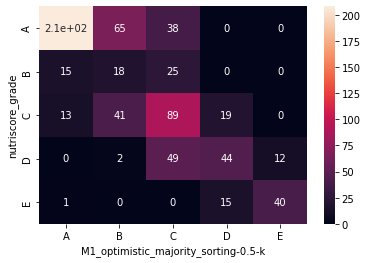

In [21]:
sns.heatmap(classifiers[max_index], annot=True)
plt.savefig('images/Methode1_MatriceConfusion_MeilleurEstimateur.png')


In [22]:
Reports[max_index][1]

,precision,recall,f1-score
A,0.877637,0.668810,0.759124
B,0.142857,0.310345,0.195652
C,0.442786,0.549383,0.490358
D,0.564103,0.411215,0.475676
E,0.769231,0.714286,0.740741
accuracy,0.574928,0.574928,0.574928
macro avg,0.559323,0.530808,0.532310
weighted avg,0.657634,0.574928,0.604110


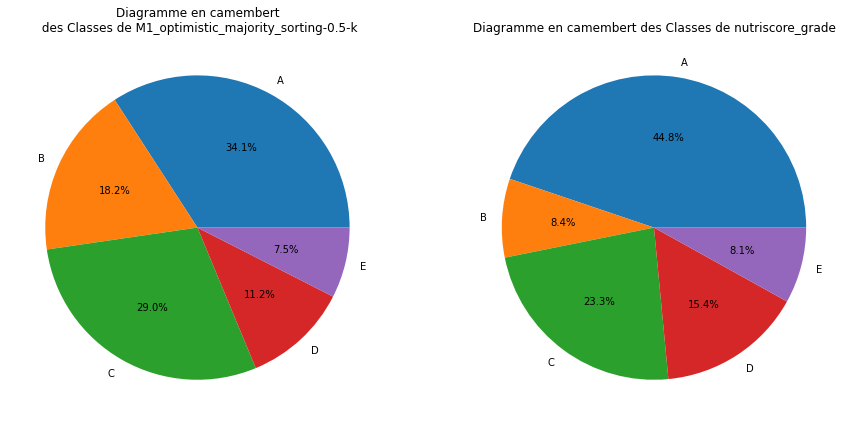

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15, 15))

# AX1
col = df[[Reports[max_index][0].split(" ,")[0]]]
ax1.pie(col.value_counts().sort_values().sort_index(),autopct='%1.1f%%', labels =['A', 'B', 'C', 'D', 'E'])
#ax1.legend(col.value_counts().index)
ax1.set_title('Diagramme en camembert\n des Classes de '+L[max_index][2])
# AX2
col = df['nutriscore_grade']
ax2.pie(col.value_counts().sort_values().sort_index(),autopct='%1.1f%%', labels =['A', 'B', 'C', 'D', 'E'])
#ax2.legend(col.value_counts().index)
ax2.set_title('Diagramme en camembert des Classes de nutriscore_grade')

plt.savefig('images/Methode1_Comparaison_MeilleurEstimateur.png')
plt.show()

## 2.2 Méthode 2 pour définir les profils limites pour chaque classe : 

### 2.2.2 Paramétrage des profils limites

Dans cette partie, nous proposons une nouvelle méthode pour paramétrer les profils limites: on prend les quartiles (25,50,75) et interquatiles (q(75)-q(25)) pour chaque classe du NutriScore qu'on a ensuite affecté à nos profils b2, b3, b4, b5.

De même, pour les profils b1 et b6, on met des valeurs inatteignables pour être sur de ne pas les dépasser lors du surclassement.

In [24]:
# Méthode 2 pour définir les profils limites pour chaque classe : 
def Q(n):
    u={'Energie':0,'Acide Gras':0,'Sucre':0,'Sodium':0,'Proteine':0,'Fibre':0,'Teneur en fruits':0}
    L_min=['Energie','Acide Gras','Sucre','Sodium']
    L_max=['Proteine','Fibre','Teneur en fruits']
    for i in u:
        if(i in L_min):
            u[i]=np.percentile(df[i],100-n)
        if(i in L_max):
            u[i]=np.percentile(df[i],n)
            
    return u


b1 = {'Energie':100000,'Acide Gras':1000,'Sucre':1000,'Sodium':10000,'Proteine':-1,'Fibre':-1,'Teneur en fruits':-1}
b2 = Q(25)
b4 = Q(50)
b5 = Q(75)
b6 = {'Energie':-1,'Acide Gras':-1,'Sucre':-1,'Sodium':-1,'Proteine':300,'Fibre':300,'Teneur en fruits':101}

In [25]:
u = {'Energie':0,'Acide Gras':0,'Sucre':0,'Sodium':0,'Proteine':0,'Fibre':0,'Teneur en fruits':0}
L_min = ['Energie','Acide Gras','Sucre','Sodium']
for i in Q(50):
    if(i in L_min):
        u[i] = Q(25)[i]-Q(75)[i]
    else:
        u[i] = Q(75)[i]-Q(25)[i]
# rearangement pour respecter la pareto-dominance des profils
b3 = u      
b3['Proteine'] = b4['Proteine']
b3['Fibre'] = b4['Fibre']
b3['Teneur en fruits'] = b4['Teneur en fruits']
b4['Proteine'] = u['Proteine']
b4['Fibre'] = u['Fibre']
b4['Teneur en fruits'] = u['Teneur en fruits']

### Voila notre dataframe des profils

In [26]:
df_profils_2 = pd.concat([pd.DataFrame(b1,index=['b1']),pd.DataFrame(b2,index=['b2']),pd.DataFrame(b3,index=['b3']),pd.DataFrame(b4,index=['b4']),pd.DataFrame(b5,index=['b5']),pd.DataFrame(b6,index=['b6'])])
df_profils_2


,Energie,Acide Gras,Sucre,Sodium,Proteine,Fibre,Teneur en fruits
b1,100000.00,1000.0,1000.0,10000.0,-1.000,-1.0,-1.0
b2,1038.50,5.0,11.0,400.0,2.300,0.0,0.0
b3,793.25,4.8,10.0,360.0,4.600,1.0,0.0
b4,518.00,1.8,3.1,212.0,4.600,1.0,0.0
b5,245.25,0.2,1.0,40.0,9.375,2.2,50.0
b6,-1.00,-1.0,-1.0,-1.0,300.000,300.0,101.0


#### Choix des poids

Les poids sont les mêmes que pour la méthode 1. On montre ici le dataframe des poids :

In [27]:
df_poids

,Energie,Acide Gras,Sucre,Sodium,Proteine,Fibre,Teneur en fruits
k,2.0,2.00,2.00,2.00,1.00,1.00,1.00
k1,0.7,0.69,0.18,0.29,0.42,0.35,0.51


Le code ci-dessous montre bien qu'on a bien une dominance pareto-stricte entre bi+1 et bi

In [28]:
P = [b6,b5,b4,b3,b2,b1] 
y = 6
for i in range(len(P)-1):
    print("b"+str(y-i),",","b"+str(y-(i+1)),", C =",C(P[i],P[i+1],k))

b6 , b5 , C = 1.0
b5 , b4 , C = 1.0
b4 , b3 , C = 1.0
b3 , b2 , C = 1.0
b2 , b1 , C = 1.0


### 2.2.3 Comparaison à l'aide de matrices de confusion avec le Nutri-Score


### Rapport avec les matrices de confusion pour chaque couple de poids, le seuil majoritaire et les procédures d’affectation Pessimiste et Optimiste de la méthode ÉLECTRE-TRI


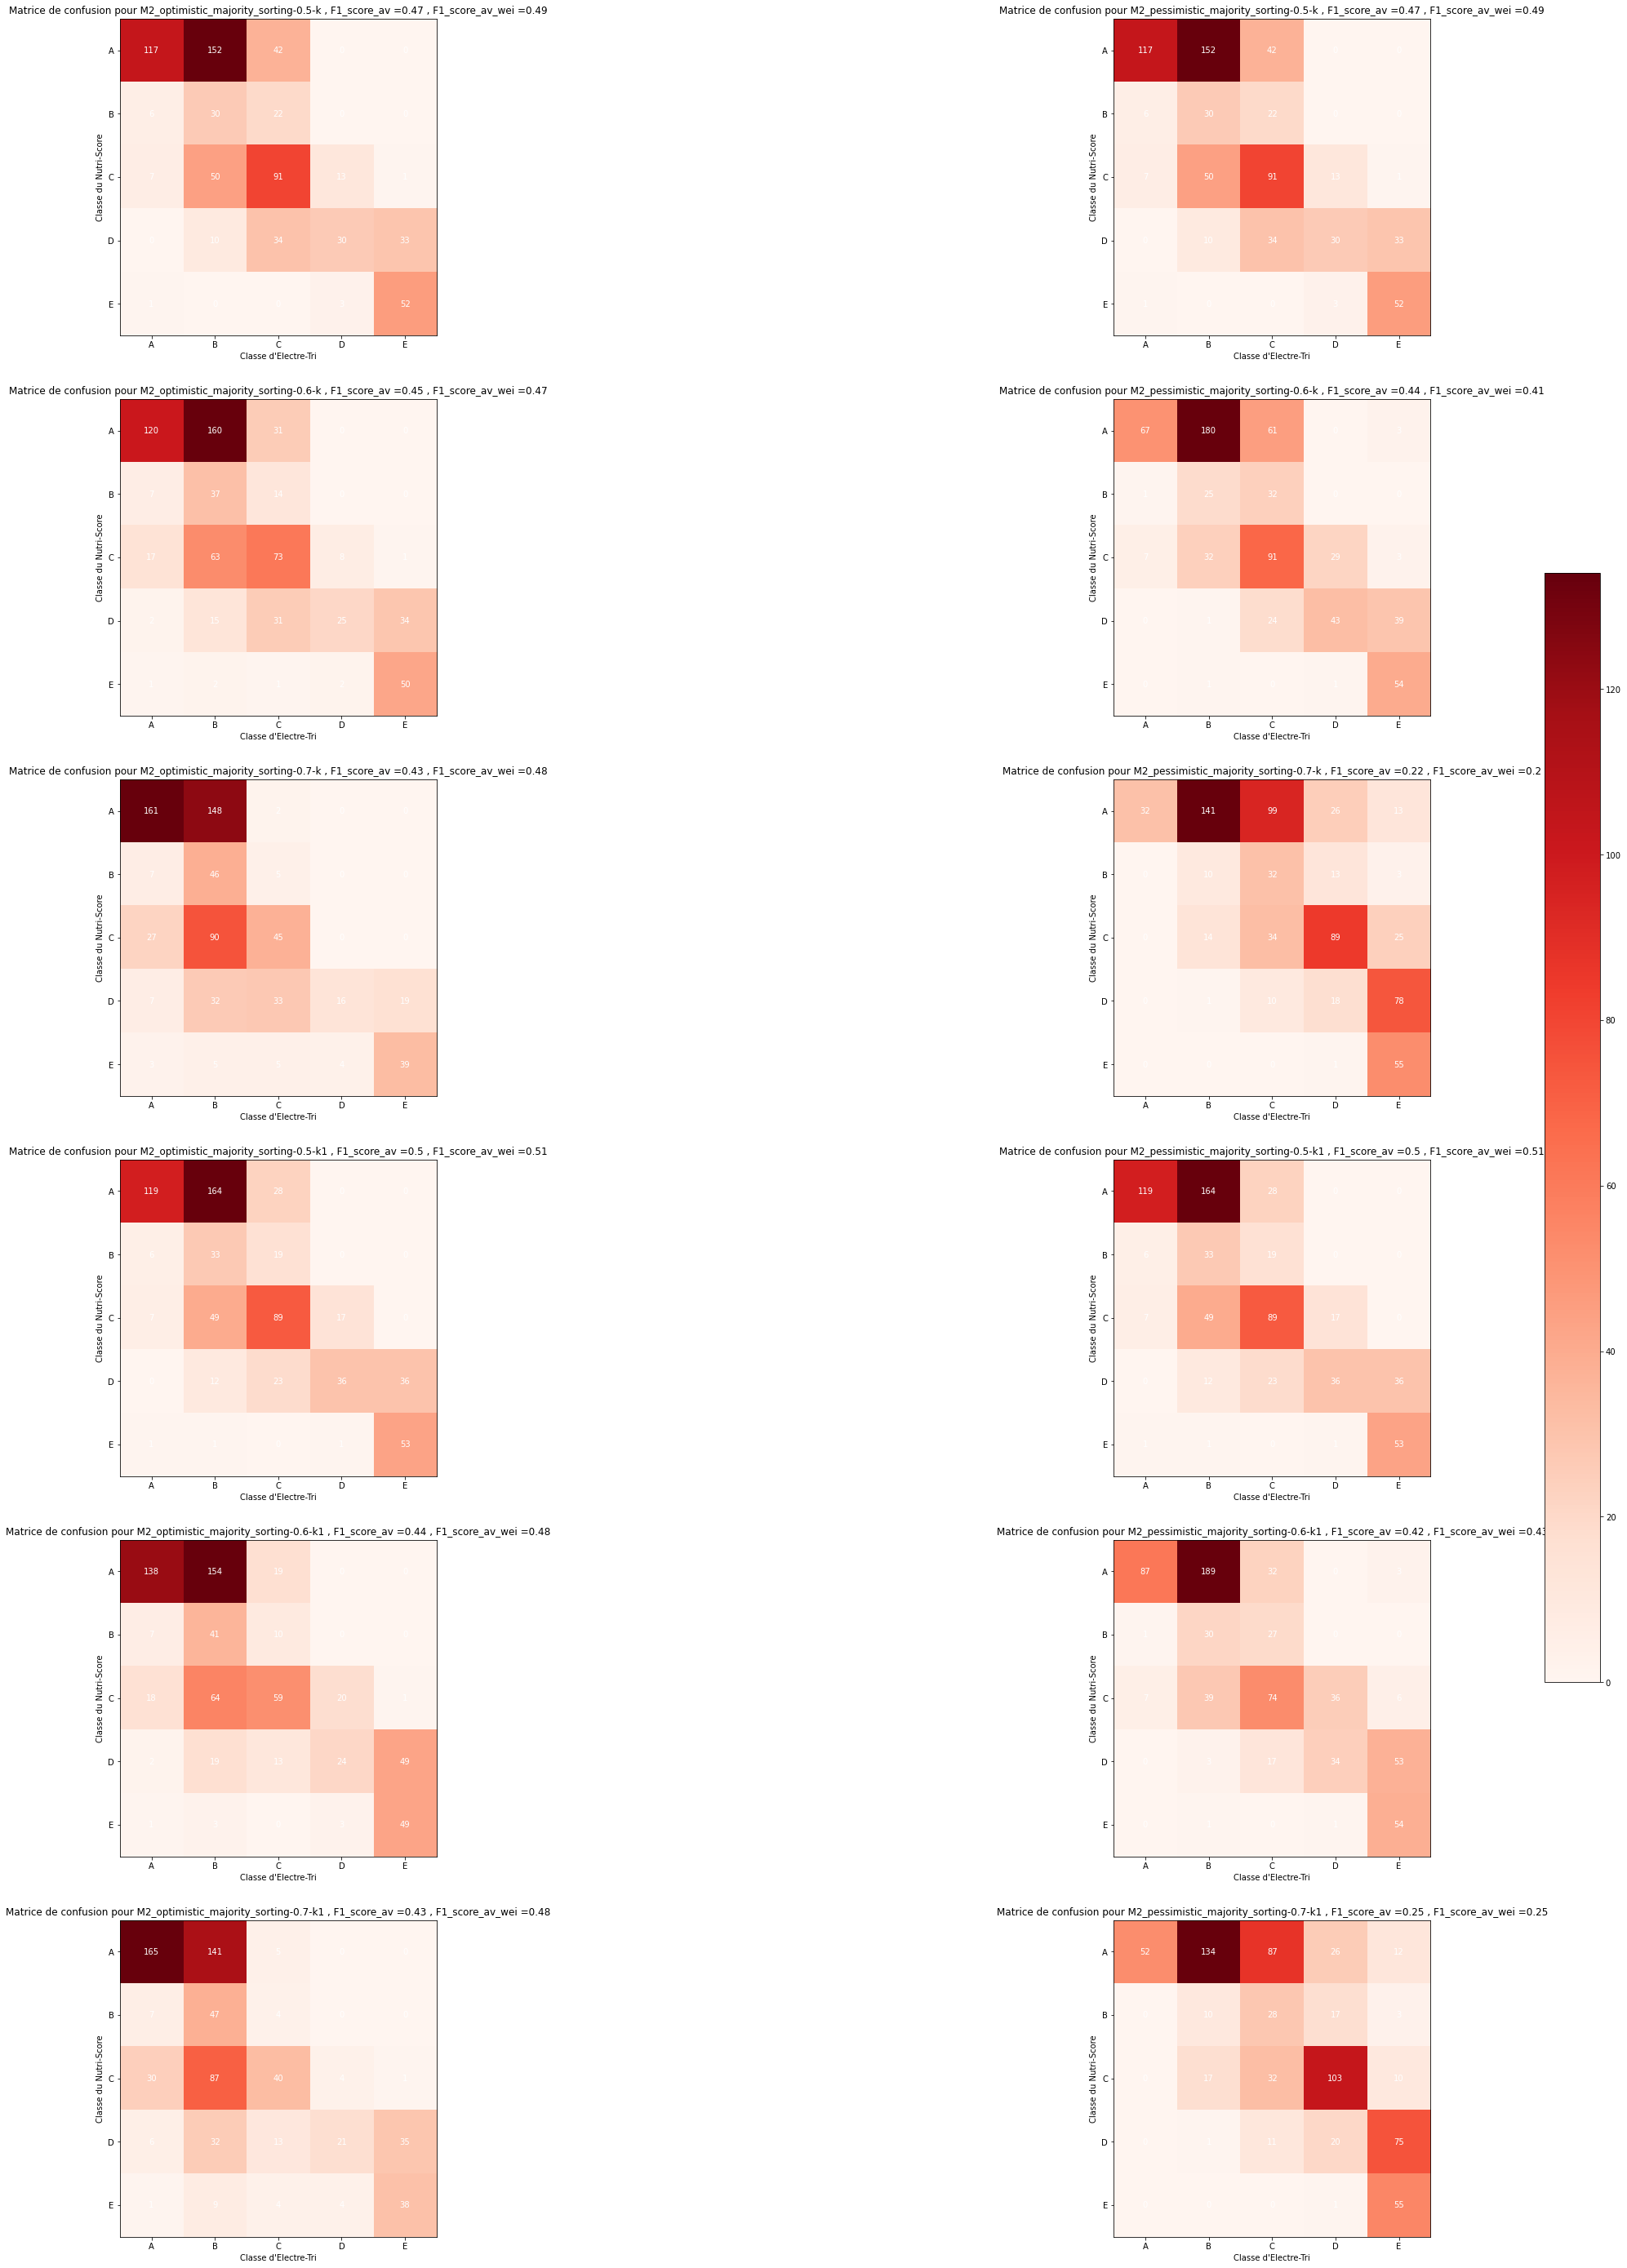

In [29]:
L_k = [(k, 'k'), (k1, 'k1')]
L_s = [0.5, 0.6, 0.7]
L_f = [optimistic_majority_sorting, pessimistic_majority_sorting]
classifiers = []
Reports = []
nb_ligne = 6
nb_col = 2

if nb_ligne * nb_col != len(L_k) * len(L_s) * len(L_f):
    print("erreur de taille")
    exit()

fig, axs = plt.subplots(nb_ligne, nb_col, figsize=(50, 50))
L=[]
ims = []
i = 0
ii = 0
for ki in L_k:
    for s in L_s:
        for f in L_f:
            matrice, titre, report, l = afficher_matrice_confusion(f, ki[0], ki[1], s,'M2_')
            L.append(l)
            Reports.append((titre,report))
            x_labels = matrice.columns
            y_labels = matrice.columns
            classifiers.append(matrice)
            im = axs[ii][i % nb_col].imshow(classifiers[i], cmap='Reds')
            axs[ii][i % nb_col].xaxis.set_major_locator(FixedLocator(range(len(x_labels))))
            axs[ii][i % nb_col].set_xticklabels(x_labels)
            axs[ii][i % nb_col].yaxis.set_major_locator(FixedLocator(range(len(y_labels))))
            axs[ii][i % nb_col].set_yticklabels(y_labels)
            axs[ii][i % nb_col].set_title('Matrice de confusion pour ' + titre)
            axs[ii][i % nb_col].set_xlabel("Classe d'Electre-Tri")
            axs[ii][i % nb_col].set_ylabel('Classe du Nutri-Score')
            ims.append(im)
            for u in range(classifiers[i].shape[0]):
                for j in range(classifiers[i].shape[1]):
                    axs[ii][i % nb_col].text(j, u, classifiers[i].iloc[u, j], ha='center', va='center', color='w')
            i += 1
            if i % nb_col == 0:
                ii += 1

fig.colorbar(im, ax=axs, shrink=0.5)
plt.savefig('images/Methode2_matricesDeConfusion.png')
plt.show()

### Rapport avec les Graphique de Recall, Précision et F1-score pour chaque couple de poids, le seuil majoritaire et les procédures d’affectation Pessimiste et Optimiste de la méthode Électre-Tri


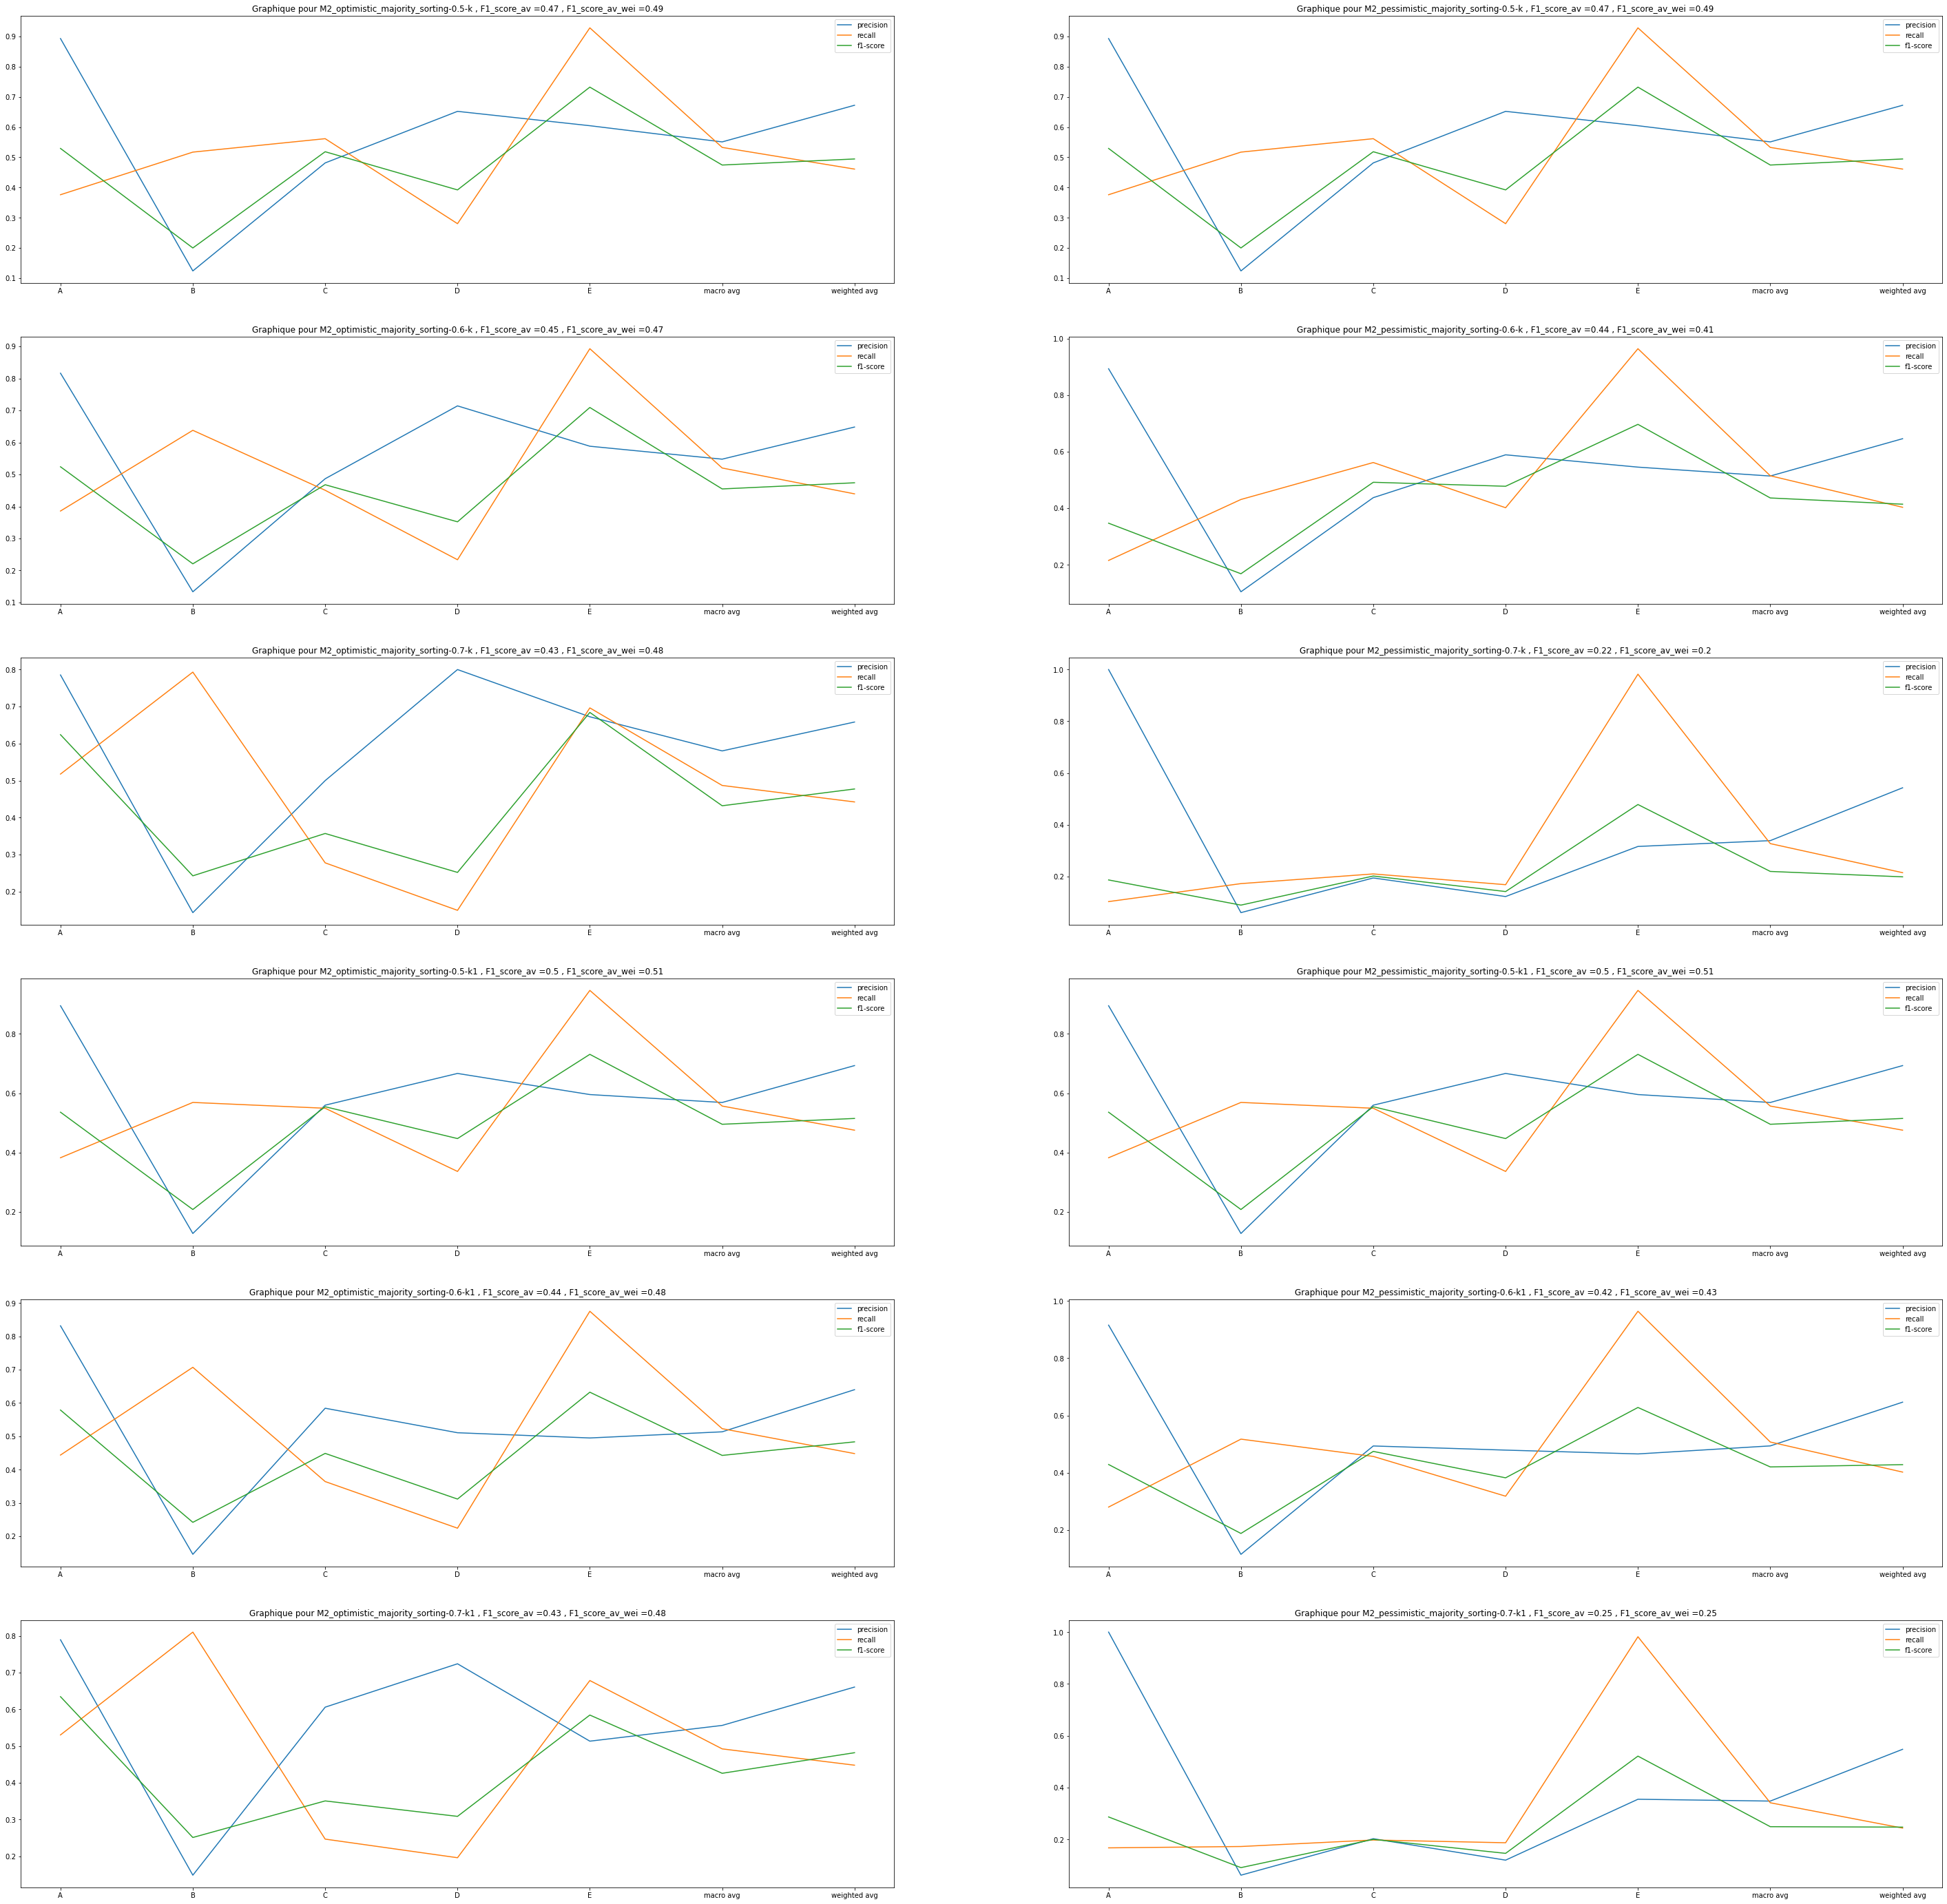

In [30]:
fig, axs = plt.subplots(nb_ligne, nb_col, figsize=(50, 50))
i = 0
ii = 0
for r in Reports:
    axs[ii][i % nb_col].set_title('Graphique pour ' + r[0])
    tmp = r[1].drop(index='accuracy')
    tmp.plot(ax=axs[ii][i % nb_col])
    i = i+1
    if i % nb_col == 0:
        ii += 1
plt.savefig('images/Methode2_Graphiques.png')
plt.show()

### Voici la matrice de Confusion et le rapport du meilleur Estimateur

In [31]:
max_index = max(enumerate(L), key=lambda x: x[1][1])[0]
tt = L[max_index][2].split('-')
print("Voici la meilleure fonction :",tt[0],"qui maximise le F1-score_average_weighted :",L[max_index][1],"\navec le seuil = ",tt[1],"et le tableau de poids :",tt[2])


Voici la meilleure fonction : M2_optimistic_majority_sorting qui maximise le F1-score_average_weighted : 0.51 
avec le seuil =  0.5 et le tableau de poids : k1


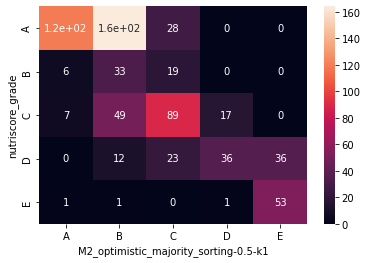

In [32]:
sns.heatmap(classifiers[max_index], annot=True)
plt.savefig('images/Methode2_MatriceConfusion_MeilleurEstimateur.png')

In [33]:
Reports[max_index][1]

,precision,recall,f1-score
A,0.894737,0.382637,0.536036
B,0.127413,0.568966,0.208202
C,0.559748,0.549383,0.554517
D,0.666667,0.336449,0.447205
E,0.595506,0.946429,0.731034
accuracy,0.475504,0.475504,0.475504
macro avg,0.568814,0.556772,0.495399
weighted avg,0.693104,0.475504,0.514991


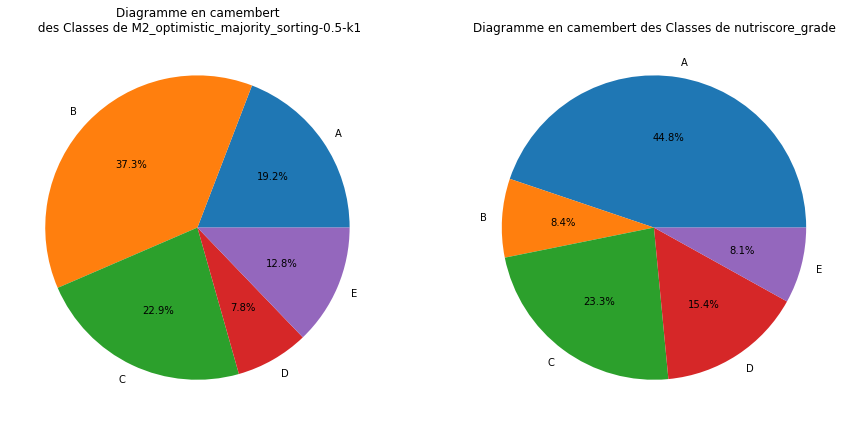

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15, 15))

# AX1
col = df[[Reports[max_index][0].split(" ,")[0]]]
ax1.pie(col.value_counts().sort_values().sort_index(),autopct='%1.1f%%', labels =['A', 'B', 'C', 'D', 'E'])
#ax1.legend(col.value_counts().index)
ax1.set_title('Diagramme en camembert\n des Classes de '+L[max_index][2])
# AX2
col = df['nutriscore_grade']
ax2.pie(col.value_counts().sort_values().sort_index(),autopct='%1.1f%%', labels =['A', 'B', 'C', 'D', 'E'])
#ax2.legend(col.value_counts().index)
ax2.set_title('Diagramme en camembert des Classes de nutriscore_grade')

plt.savefig('images/Methode2_Comparaison_MeilleurEstimateur.png')
plt.show()

# 3. Élaboration d’un modèle Super Nutri-Score

Dans cette partie, nous proposons une nouvelle démarche pour élaborer un Super Nutri-Score qui combine les propriétés du Nutri-Score et de la classification NOVA.

La classification NOVA assigne un groupe aux produits alimentaires en fonction du degré de transformation qu’ils ont subi selon une échelle allant de 1 pour les produits les moins transformés à 4 pour les produits les plus transformés. Nous avons eu l’idée d’une approche par pénalisation.

On remarque que plus la valeur du Nutri-Score est faible, plus le produit est de qualité. Donc, nous avons décidé de re-transformer le score Nova pour avoir une pénalisation du Nutri-Score, si le Nova est élevé.

Nous avons pensé à rajouter une pondération pour avoir un résultat ou le nutri-score aurait plus d'importance, mais il nous a semblé plus judicieux de simplement ajouter le score Nova.

Nous avons choisi de décaler le score Nova de -1, pour ne pas pénaliser les produits les plus sains.

In [35]:
def nova_nutri(product):
    '''new_notes ={
    "A" : (-15, -1),
    "B" : (0, 2),
    "C" : (3, 10),
    "D" : (11,18),
    "E" : (19, 43)
    }'''
    
    new_notes ={
    "A" : (-15, 0),
    "B" : (1, 3),
    "C" : (4, 11),
    "D" : (12,19),
    "E" : (20, 43)
    }

    nutriscore = float(product["nutriscore_score"])

    nova = float(product["nova_grade"])
    
    ponderation_nutriscore = 1 #0.65
    ponderation_nova = 1 #0.35

    # Calcul de la valeur combinée
    valeur_combinee = ponderation_nutriscore * nutriscore + ponderation_nova * (nova-1)
    
    for k,v in new_notes.items():
        if v[0] <= valeur_combinee <= v[1]:
            return k

In [36]:
df['nova_nutri'] = df.apply(lambda x : nova_nutri(x),axis=1)

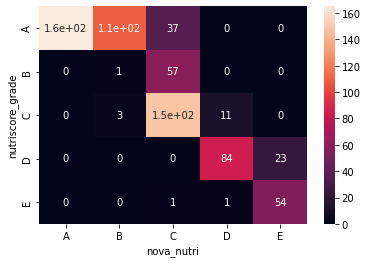

In [37]:
sns.heatmap(pd.crosstab(df['nutriscore_grade'], df['nova_nutri']), annot=True)
plt.savefig('images/MatriceDeConfusion_nova_nutri.png')

In [38]:
dic = classification_report(df['nutriscore_grade'], df['nova_nutri'],output_dict=True)
pd.DataFrame(dic).transpose()

,precision,recall,f1-score,support
A,1.000000,0.530547,0.693277,311.000000
B,0.008850,0.017241,0.011696,58.000000
C,0.609053,0.913580,0.730864,162.000000
D,0.875000,0.785047,0.827586,107.000000
E,0.701299,0.964286,0.812030,56.000000
accuracy,0.651297,0.651297,0.651297,0.651297
macro avg,0.638840,0.642140,0.615091,694.000000
weighted avg,0.782533,0.651297,0.675379,694.000000


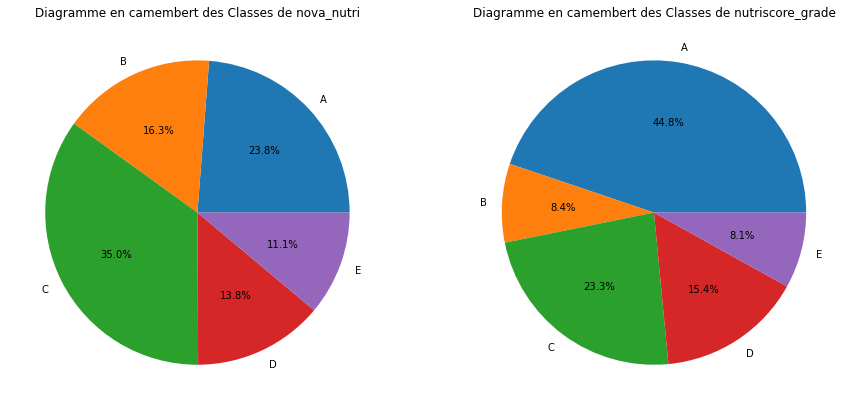

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15, 15))

# AX1
col = df['nova_nutri']
ax1.pie(col.value_counts().sort_values().sort_index(),autopct='%1.1f%%', labels =['A', 'B', 'C', 'D', 'E'])
#ax1.legend(col.value_counts().index)
ax1.set_title('Diagramme en camembert des Classes de nova_nutri')
# AX2
col = df['nutriscore_grade']
ax2.pie(col.value_counts().sort_values().sort_index(),autopct='%1.1f%%', labels =['A', 'B', 'C', 'D', 'E'])
#ax2.legend(col.value_counts().index)
ax2.set_title('Diagramme en camembert des Classes de nutriscore_grade')

plt.savefig('images/Comparaison_nova_nutri.png')
plt.show()

# 4. Élaboration des modèles de Nutri-Score basés sur une approche de somme pondérée

In [40]:
Energie = [3350, 3015, 2680, 2345, 2010, 1675, 1340, 1005, 670, 335]
Acide_Gras = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
Sucre = [45, 40, 36, 31, 27, 22.5, 18, 13.5, 9, 4.5]
Sodium = [900, 810, 720, 630, 540, 450, 360, 270, 180, 90]
Proteine = [8, 6.4, 4.8, 3.2, 1.6]
Fibre = [4.7, 3.7, 2.8, 1.9, 0.9]
Teneur_en_fruits = [80, 74, 67, 60, 40]


Classe_Nutri_Score = {'A':[-15,1],'B':[0,2],'C':[3,10],'D':[11,18],'E':[19,40]}


def points_neg(x,L):
    pt=10
    for l in L:
        if(x>l):
            return pt
        pt=pt-1
    return pt


def points_posi(x,L):
    pt=5
    for l in L:
        if(x>l):
            return pt
        pt=pt-1
    return pt


def F(x):
    # x etant un dictionnaire contenant les valeurs nutritives de l'aliment
    L_min=[('Energie',Energie),('Acide Gras',Acide_Gras),('Sucre',Sucre),('Sodium',Sodium)]
    L_max=[('Proteine',Proteine),('Fibre',Fibre),('Teneur en fruits',Teneur_en_fruits)]
    S=0
    for l in L_min:
        tmp = 10 - points_neg(x[l[0]],l[1])
        S = S + tmp
    for l in L_max:
        tmp = points_posi(x[l[0]],l[1])
        S = S + tmp
    return 40-S


def Neo(x):
    # x etant un dictionnaire contenant les valeurs nutritives de l'aliment
    L_min=[('Acide Gras',Acide_Gras),('Sucre',Sucre),('Sodium',Sodium)]
    L_max=[('Proteine',Proteine),('Fibre',Fibre),('Teneur en fruits',Teneur_en_fruits)]
    S=0
    for l in L_min:
        tmp = 10 - points_neg(x[l[0]],l[1])
        S = S + tmp
    for l in L_max:
        tmp = points_posi(x[l[0]],l[1])
        S = S + tmp
    return 40-S


def Nei(x):
    # x etant un dictionnaire contenant les valeurs nutritives de l'aliment
    L_min = [('Energie',Energie),('Sodium',Sodium)]
    L_max = [('Teneur en fruits',Teneur_en_fruits)]
    S = 0
    for l in L_min:
        tmp = 10 - points_neg(x[l[0]],l[1])
        S = S + tmp
    for l in L_max:
        tmp = points_posi(x[l[0]],l[1])
        S = S + tmp
    return 40-S


def Neo_grade(x,Classe):
    tmp = Neo(x)
    for k in Classe.keys():
        I = Classe[k]
        if(tmp >= I[0] and tmp <= I[1]):
            return k

        
def Nei_grade(x,Classe):
    tmp = Nei(x)
    for k in Classe.keys():
        I = Classe[k]
        if(tmp >= I[0] and tmp <= I[1]):
            return k

## 4.1 Cas de la fonction Neo

### 4.1.1 Redéfinition du seuil d'appartenance pour Neo

Pour redéfinir les seuils d'appartenance à chaque classe, nous avons commencé par regarder les classes extrêmes, à savoir A et E.

La meilleure note que puisse attribuer la fonction Neo à un aliment est 45. En réutilisant la formule du Nutri-Score donnée dans l'énoncé en (5) et (6), on obtient donc comme borne inférieure 40 - 45 soit -5 pour la classe A. 

Pour ce qui est de la classe E, comme la pire note que puisse attribuer la fonction Neo pour un aliment est 0, on fait 40 - 0 = 40.

Reste à adapter les intervalles de classes B, C et D. Pour ce faire, nous avons déterminé la distribution des valeurs du Nutri-Score dans l'ensemble des aliments en fonction des limites inférieure et supérieure de la classe A et de la classe E. Ensuite, nous avons réparti les aliments qui ont des valeurs de Nutri-Score comprises dans chaque intervalle de classe de manière équitable dans les différentes classes, en veillant à ce que chaque classe ait une proportion similaire d'aliments.

Ce qui nous donne :

In [41]:
Classe_Neo_Score = {'A':[-5,10],'B':[11,12],'C':[13,17],'D':[18,20],'E':[21,40]}

In [42]:
df['Neo-Nutri_Grade']=df.apply(lambda x: Neo_grade(x,Classe_Neo_Score),axis=1)

In [43]:
# On vérfie qu'on a bien tout affecté
df['Neo-Nutri_Grade'].value_counts().sum()-df['nutriscore_grade'].value_counts().sum()

0

### 4.1.2 Analyse des résultats avec une matrice de confusion

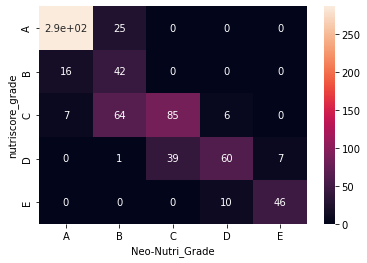

In [44]:
sns.heatmap(pd.crosstab(df['nutriscore_grade'], df['Neo-Nutri_Grade']), annot=True)
plt.savefig('images/MatriceDeConfusion_Neo.png')

### 4.1.2 Analyse avec des Mesures

In [45]:
dic = classification_report(df['nutriscore_grade'], df['Neo-Nutri_Grade'],output_dict=True)
pd.DataFrame(dic).transpose()

,precision,recall,f1-score,support
A,0.925566,0.919614,0.922581,311.000000
B,0.318182,0.724138,0.442105,58.000000
C,0.685484,0.524691,0.594406,162.000000
D,0.789474,0.560748,0.655738,107.000000
E,0.867925,0.821429,0.844037,56.000000
accuracy,0.747839,0.747839,0.747839,0.747839
macro avg,0.717326,0.710124,0.691773,694.000000
weighted avg,0.793129,0.747839,0.758341,694.000000


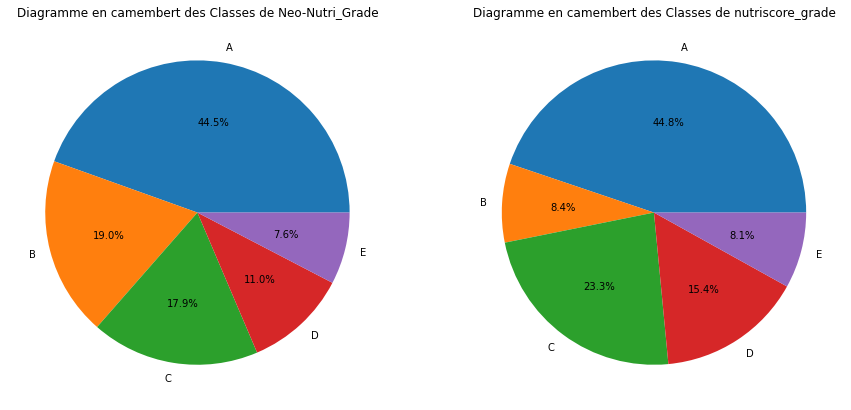

In [46]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15, 15))

# AX1
col = df['Neo-Nutri_Grade']
ax1.pie(col.value_counts().sort_values().sort_index(),autopct='%1.1f%%', labels =['A', 'B', 'C', 'D', 'E'])
#ax1.legend(col.value_counts().index)
ax1.set_title('Diagramme en camembert des Classes de Neo-Nutri_Grade')
# AX2
col = df['nutriscore_grade']
ax2.pie(col.value_counts().sort_values().sort_index(),autopct='%1.1f%%', labels =['A', 'B', 'C', 'D', 'E'])
#ax2.legend(col.value_counts().index)
ax2.set_title('Diagramme en camembert des Classes de nutriscore_grade')

plt.savefig('images/Comparaison_Neo.png')
plt.show()

## 4.2 Cas de la fonction Nei

### 4.2.1 Redéfinition du seuil d'appartenance pour Nei

Pour redéfinir les seuils d'appartenance à chaque classe, nous avons commencé par regarder les classes extrêmes, à savoir A et E.

La meilleure note que puisse attribuer la fonction Nei à un aliment est 25. En réutilisant la formule du Nutri-Score donnée dans l'énoncé en (5) et (7), on obtient donc comme borne inférieure 40 - 25 soit 15 pour la classe A. 

Pour ce qui est de la classe E, comme la pire note que puisse attribuer la fonction Neo pour un aliment est 0, on fait 40 - 0 = 40.

Reste à adapter les intervalles de classes B, C et D. Pour ce faire, nous avons déterminé la distribution des valeurs du Nutri-Score dans l'ensemble des aliments en fonction des limites inférieure et supérieure de la classe A et de la classe E. Ensuite, nous avons réparti les aliments qui ont des valeurs de Nutri-Score comprises dans chaque intervalle de classe de manière équitable dans les différentes classes, en veillant à ce que chaque classe ait une proportion similaire d'aliments.

Ce qui nous donne :

In [47]:
Classe_Nei_Score = {'A':[15,22],'B':[23,25],'C':[26,30],'D':[31,36],'E':[37,40]}

In [48]:
df['Nei-Nutri_Grade']=df.apply(lambda x: Nei_grade(x,Classe_Nei_Score),axis=1)

In [49]:
# On vérfie qu'on a bien tout affecté
df['Nei-Nutri_Grade'].value_counts().sum()-df['nutriscore_grade'].value_counts().sum()

0

### 4.2.2 Analyse avec matrice de confusion

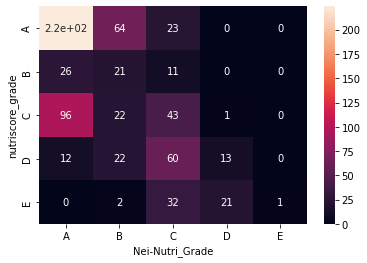

In [50]:
sns.heatmap(pd.crosstab(df['nutriscore_grade'], df['Nei-Nutri_Grade']), annot=True)
plt.savefig('images/MatriceDeConfusion_Nei.png')


### 4.2.3 Analyse avec des Mesures

In [51]:
dic = classification_report(df['nutriscore_grade'], df['Nei-Nutri_Grade'],output_dict=True)
pd.DataFrame(dic).transpose()

,precision,recall,f1-score,support
A,0.625698,0.720257,0.669656,311.000000
B,0.160305,0.362069,0.222222,58.000000
C,0.254438,0.265432,0.259819,162.000000
D,0.371429,0.121495,0.183099,107.000000
E,1.000000,0.017857,0.035088,56.000000
accuracy,0.435159,0.435159,0.435159,0.435159
macro avg,0.482374,0.297422,0.273977,694.000000
weighted avg,0.491141,0.435159,0.410373,694.000000


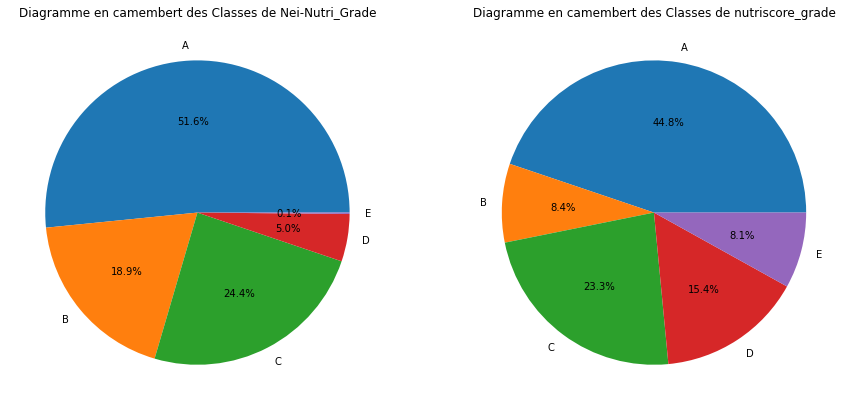

In [52]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15, 15))

# AX1
col = df['Nei-Nutri_Grade']
ax1.pie(col.value_counts().sort_values().sort_index(),autopct='%1.1f%%', labels =['A', 'B', 'C', 'D', 'E'])
#ax1.legend(col.value_counts().index)
ax1.set_title('Diagramme en camembert des Classes de Nei-Nutri_Grade')
# AX2
col = df['nutriscore_grade']
ax2.pie(col.value_counts().sort_values().sort_index(),autopct='%1.1f%%', labels =['A', 'B', 'C', 'D', 'E'])
#ax2.legend(col.value_counts().index)
ax2.set_title('Diagramme en camembert des Classes de nutriscore_grade')

plt.savefig('images/Comparaison_Nei.png')
plt.show()

### Implémentation des méthodes PessimisticmajoritySorting et OptimisticmajoritySorting de façon à ce qu'elles prennent en entrée un fichier Excel contenant les produits alimentaires et leur Nutri-Score originel.

Ces fonctions renvoient un nouveau fichier excel avec les aliments et leur nouveau classement.

In [53]:
def pessimistic_majority_sorting_excel(nom_fichier_excel):
    
    # ATTENTION LES COLONNES DOIVENT ETRE BIEN NOMMÉES :
    # Energie, Acide Gras, Sucre, Sodium, Proteine, Fibre, Teneur en fruits, categories
    
    df = pd.read_excel(nom_fichier_excel)
    df = df.set_index('name')
    df.drop_duplicates(keep=False,inplace=True)
    
    # Initialisation - On utilise le poids de base
    k = {'Energie':2,'Acide Gras':2,'Sucre':2,'Sodium':2,'Proteine':1,'Fibre':1,'Teneur en fruits':1}
    L_s = [0.5, 0.6, 0.7]
    
    #On applique pour chaque seuil la fonction
    for s in L_s:
        titre = 'pessimistic_majority_sorting'+str(s)
        df[titre] = df.apply(lambda x : pessimistic_majority_sorting(x,s,k),axis=1)
    
    output_excel = df.drop(columns='categories')
    output_excel.to_excel("output_pessmistic_sorting.xls")

def optimistic_majority_sorting_excel(nom_fichier_excel):
    
    # ATTENTION LES COLONNES DOIVENT ÊTRE BIEN NOMMÉES :
    # Energie, Acide Gras, Sucre, Sodium, Proteine, Fibre, Teneur en fruits
    
    df = pd.read_excel(nom_fichier_excel)
    df = df.set_index('name')
    df.drop_duplicates(keep=False,inplace=True)
    
    # Initialisation - On utilise le poids de base
    k = {'Energie':2,'Acide Gras':2,'Sucre':2,'Sodium':2,'Proteine':1,'Fibre':1,'Teneur en fruits':1}
    L_s = [0.5, 0.6, 0.7]
    
    #On applique pour chaque seuil la fonction
    for s in L_s:
        titre = 'optimistic_majority_sorting'+str(s)
        df[titre] = df.apply(lambda x : optimistic_majority_sorting(x,s,k),axis=1)
    
    output_excel = df.drop(columns='categories')
    output_excel.to_excel("output_optimistic_sorting.xls")

In [54]:
pessimistic_majority_sorting_excel("bdd_nutriscore.xlsx")

In [55]:
optimistic_majority_sorting_excel("bdd_nutriscore.xlsx")